#Supervised Learning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import operator

First, let's load our dataframe with features calculated in the feature selection notebook:

In [2]:
%%time

import cPickle
import praw

df = cPickle.load(open('df_features.p', 'rb'))

CPU times: user 1min 31s, sys: 1min, total: 2min 31s
Wall time: 2min 51s


In [12]:
df.head(3)

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by,syn_count,syn_perc,un_length,un_punc,un_case,un_number,un_PM,un_bot
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,0,0,2485,AskReddit,36ih74,2485,60,7011,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,14,0,2,0.000000,0,0
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,0,1,4983,AskReddit,36ih74,4983,63,3024,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,2,0.333333,0,0
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,0,0,2386,AskReddit,36ih74,2386,46,6330,10,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,0,0,0.000000,0,0


##Baseline

In [13]:
dftouse = df.copy()

Begin by standardizing the parts of the data that are integers or floats:

In [14]:
STANDARDIZABLE = ['created', 'created_utc', 'character_count', 'time_delay', 'word_count', 'swear_count',
                 'word_size', 'link_count', 'italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count',
                 'paragraph_count', 'syn_count', 'syn_perc', 'un_length', 'un_punc', 'un_case', 'un_number']

In [125]:
from sklearn.preprocessing import StandardScaler

def standardize(orig_df, change_df):
    for col in STANDARDIZABLE:
        valstrain = orig_df[col].values[mask]
        valstest = orig_df[col].values[~mask]
        scaler = StandardScaler().fit(valstrain)
        outtrain = scaler.transform(valstrain)
        outtest = scaler.fit_transform(valstest)
        out = np.empty(mask.shape[0])
        out[mask] = outtrain
        out[~mask] = outtest
        change_df[col] = out

standardize(df, dftouse)

Create the training and testing sets.

In [127]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

Let's build a baseline where we simply guess the number of upvotes a post will get by guessing using the mean and the median of the test set. 

In [128]:
def baseline(indf, mask):
    X = indf['ups']
    if mask !=None:
        Xtrain, Xtest = X[mask], X[~mask]

    mean = np.mean(Xtrain)
    median = np.median(Xtrain)
    print mean, median
    training_error_mean = abs(Xtrain - mean)
    training_error_median = abs(Xtrain - median)
    
    test_error_mean = abs(Xtest - mean)
    test_error_median = abs(Xtest - median)
    
    training_accuracy1 = np.mean(training_error_mean)
    training_accuracy2 = np.mean(training_error_median)
    test_accuracy1 = np.mean(test_error_mean)
    test_accuracy2 = np.mean(test_error_median)
    
    print "############# Baseline Accuracy ########################"
    print "Accuracy on training data using mean:   %0.2f" % (training_accuracy1)
    print "Accuracy on training data using median: %0.2f" % (training_accuracy2)
    print "Accuracy on test data using mean:       %0.2f" % (test_accuracy1)
    print "Accuracy on test data using median:     %0.2f" % (test_accuracy2)
    print "########################################################"

In [129]:
baseline(dftouse, mask)

79.3385934016 2.0
############# Baseline Accuracy ########################
Accuracy on training data using mean:   144.13
Accuracy on training data using median: 77.75
Accuracy on test data using mean:       148.93
Accuracy on test data using median:     82.87
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


##Adjustments, Processing, and Some Functions

First, let's create a smaller dataframe ```minidf``` to test models that take longer to run -- below, we randomly sample 10,000 rows in the original dataframe, and create a mask for ```minidf```.

In [130]:
import random
rows = random.sample(dftouse.index, 10000)
minidf = dftouse.ix[rows]

In [131]:
from sklearn.cross_validation import train_test_split
itrain2, itest2 = train_test_split(xrange(minidf.shape[0]), train_size=0.7)

mask2=np.ones(minidf.shape[0], dtype='int')
mask2[itrain2]=1
mask2[itest2]=0
mask2 = (mask2==1)

Another thing to note is that our data is very skewed: the vast majority of the comments have scores < 5, while the highest scoring comments have scores > 7000.

In [116]:
print "# comments with scores < 5", len(dftouse[dftouse['ups'] < 5])
print "# comments with scores > 7000", len(dftouse[dftouse['ups'] > 7000])

# comments with scores < 5 135285
# comments with scores > 7000 16


This heavily skewed data can cause our models to do poorly. We thus try to adjust by taking the log of the number of upvotes, stored in ```log_df```.

In [67]:
log_df = dftouse.copy()
log_df['ups'] = dftouse['ups'].map(lambda x: np.log(x))

Note the columns that we want to use as features in the regression.

In [190]:
cols = ['created_utc',
        'time_delay',
        'word_count',
        'character_count',
        'swear_count',
        'word_size',
        'link_count',
        'italics_count',
        'bold_count',
        'strikethrough_count',
        'blockquote_count',
        'paragraph_count',
        'syn_count',
        'syn_perc',
        'un_length',
        'un_punc',
        'un_case',
        'un_number',
        'un_PM',
        'un_bot'
        ]

Below is the function for optimizing parameters:

In [191]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

Below is the function to handle the regressions:

In [192]:
from sklearn.metrics import confusion_matrix

def classify(clf, parameters, indf, featurenames, targetname, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    # print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

##Botany and Ensemble Methods

###Decision Trees

We first try regression using Decision Trees; note that we use ```log_df```. The main issue for decision trees is overfitting -- from [the documentation](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use), to get a feel for how the tree is fitting the data, we use ```max_depth=3``` and ```min_samples_leaf=5```, then visualize the tree. 

In [193]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [194]:
%%time

parameters = {"max_depth": [3], 'min_samples_leaf': [5]}
clftree, Xtrain, ytrain, Xtest, ytest = classify(
                              DecisionTreeRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

tree.export_graphviz(clftree, out_file='tree.dot') # get the tree as a dot file, then convert to png

mask
BEST {'max_depth': 3, 'min_samples_leaf': 5} -0.733127291569 [mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 5}]
############# based on standard predict ################
Accuracy on training data: 0.28
Accuracy on test data:     0.28
########################################################
CPU times: user 2.37 s, sys: 190 ms, total: 2.56 s
Wall time: 2.71 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Below is the tree that results from ```max_depth=3``` and ```min_samples_leaf=5```: 

![Image of decision tree](images/decisiontree.png)

Judging by the MSE (mean squared error) of the children, we are not overfitting. We thus increase ```max_depth``` and ```min_samples_leaf```. We also save the feature importances in ```tree_feats```.

In [195]:
%%time

parameters = {"max_depth": [3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clftree, Xtrain, ytrain, Xtest, ytest = classify(
                              DecisionTreeRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

tree_feats = zip(cols, clftree.feature_importances_)

mask
BEST {'max_depth': 4, 'min_samples_leaf': 5} -0.724749544048 [mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 1}, mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 2}, mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 3}, mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 4}, mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 5}, mean: -0.73313, std: 0.02627, params: {'max_depth': 3, 'min_samples_leaf': 6}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samples_leaf': 1}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samples_leaf': 2}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samples_leaf': 3}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samples_leaf': 4}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samples_leaf': 5}, mean: -0.72475, std: 0.01835, params: {'max_depth': 4, 'min_samp

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Not too hot for accuracy scores. Let's look at the mean absolute error:

In [196]:
print np.mean(abs(np.exp(clftree.predict(Xtest)) - np.exp(ytest)))

81.250330521


This is barely better than the baseline of the median!

###Random Forests

Now, let's try Random Forests. According to [the documentation](http://scikit-learn.org/stable/modules/ensemble.html#parameters), the main parameters to adjuct are ```n_estimators``` and ```max_features```. 

* ```n_estimators``` is the number of trees in the forest -- the more trees, the better but longer to compute. 

* ```max_features``` is the number of random subsets of features to consider when splitting a node. The documentation states that empirically, the default value of n_features (the number of features) is the best for regression.

* Good results can be achieved when using ```min_samples_split = 1```. ```min_samples_split``` is the minimum number of samples needed to split an internal node -- the default is 2, but if we set it equal to 1, the trees are fully developed (which has the downfall of using lots of RAM). 

* Finally, since we are building lots of trees, we want to run this in parallel: we thus set ```n_jobs=-1```, which means that the number of jobs is set to the number of cores.

In [197]:
from sklearn.ensemble import RandomForestRegressor

We run the regression below, and save the feature importances in ```forest_feats```.

In [ ]:
%%time

parameters = {'n_estimators': range(10, 50), 
              'min_samples_split': [1, 2], 'n_jobs': [-1]}
clfforest, Xtrain, ytrain, Xtest, ytest = classify(
                              RandomForestRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

forest_feats = zip(cols, clfforest.feature_importances_)

In [156]:
print np.mean(abs(np.exp(clfforest.predict(Xtest)) - np.exp(ytest)))

80.7562034166


###Feature Weighting

Let's take a look at how each model weighted the features we provided it. First, random forests:

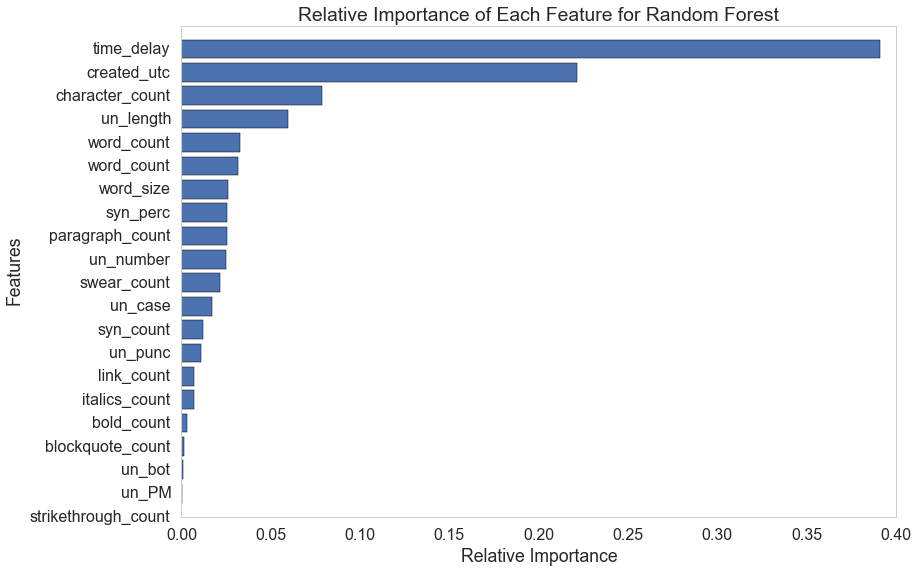

In [186]:
forest_feat_sort = sorted(forest_feats, key=lambda x: x[1])
plt.barh(range(len(forest_feats)), [x[1] for x in forest_feat_sort], align='center')
plt.yticks(range(len(forest_feats)), [x[0] for x in forest_feat_sort])
plt.title('Relative Importance of Each Feature for Random Forest')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

Time was the most important factors, with ```time_delay``` as the most important feature, and ```created_utc``` coming in second. Also, the more general features were also ranked more important, such as ```character_count```,  ```word_count```, and ```un_length```, while the more obscure features like markdown and ```un_punc``` were less important.

Now let's look at decision trees: 

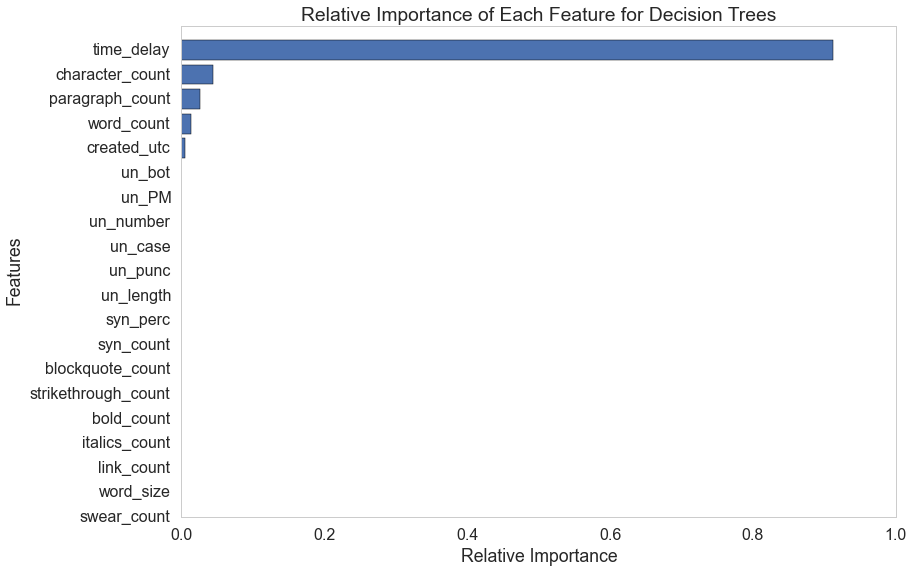

In [198]:
tree_feat_sort = sorted(tree_feats, key=lambda x: x[1])
plt.barh(range(len(tree_feats)), [x[1] for x in tree_feat_sort], align='center')
plt.yticks(range(len(tree_feats)), [x[0] for x in tree_feat_sort])
plt.title('Relative Importance of Each Feature for Decision Trees')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

The distribution for decision trees is much more skewed, with a very heavy weighting on ```time_delay```. Interestingly, counts related to the comment body (```character_count```, ```paragraph_count```, and ```word_count```) come before the ```created_utc```, while the other features seem basically irrelevant.

Below is a comparison of the two graphs: the relative importance is more distributed for random forests compared to decision trees.

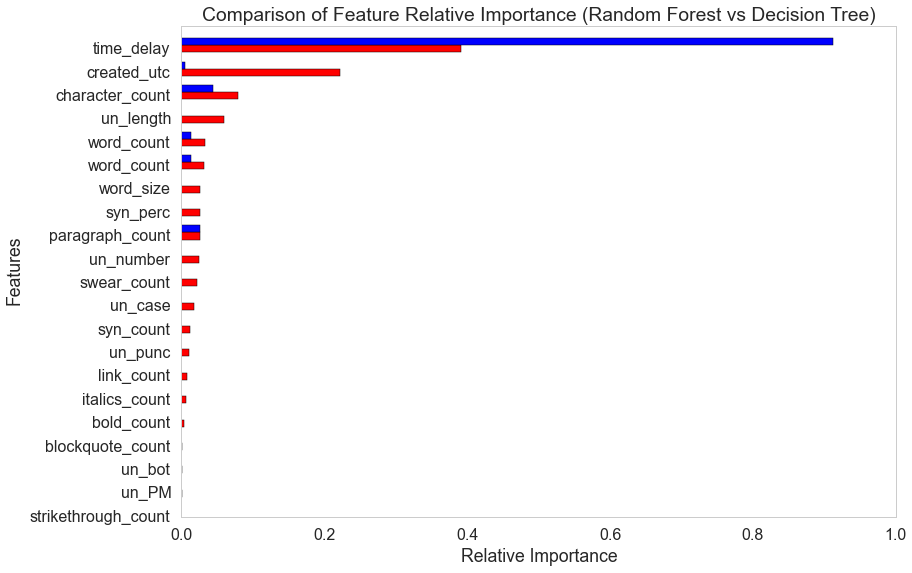

In [189]:
tree_feat_d = {x[0]:x[1] for x in tree_feats}
ordered_tree_feat = [tree_feat_d[x[0]] for x in forest_feat_sort]
bar_width = 0.3
plt.barh(range(len(forest_feats)), [x[1] for x in forest_feat_sort], bar_width, align='center', color='r')
plt.barh([i + bar_width for i in range(len(forest_feats))], ordered_tree_feat, bar_width, align='center', color='b')
plt.yticks(range(len(forest_feats)), [x[0] for x in forest_feat_sort])
plt.title('Comparison of Feature Relative Importance (Random Forest vs Decision Tree)')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

##Logistic Regression with Lasso

Run the regression:

In [82]:
from sklearn.linear_model import LogisticRegression

In [134]:
%%time

clflog, Xtrain, ytrain, Xtest, ytest = classify(
                              LogisticRegression(penalty="l1"),
                              {"C": [0.1]}, 
                              minidf, 
                              cols,
                              'ups',
                              mask = mask2,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

mask
BEST {'C': 0.1} -87.7792857143 [mean: -87.77929, std: 134.49530, params: {'C': 0.1}]
############# based on standard predict ################
Accuracy on training data: 0.43
Accuracy on test data:     0.43
########################################################
CPU times: user 22 s, sys: 1.28 s, total: 23.2 s
Wall time: 23.5 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [135]:
print np.mean(abs(clflog.predict(Xtest) - ytest))

73.4613333333
